In [1]:
from datetime import datetime
import pandas as pd
from geopy import distance
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import normalize

import statsmodels.api as sm


import pymongo
from pymongo import MongoClient

import matplotlib.pyplot as plt

plt.style.use("ggplot")

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
client = MongoClient('localhost', 27017)

db = client['avl_pipeline_test']
in_coll = db['labeled_trips']
coll = db['trips']

In [24]:
duration_cursor = coll.find({}, {'_id': 0, 'trip_duration': 1, 'first_timestamp': 1}).sort('first_timestamp')

In [25]:
ts = []
duration = []

for trip_deets in duration_cursor:
    ts.append(trip_deets['first_timestamp'])
    duration.append(trip_deets['trip_duration'])

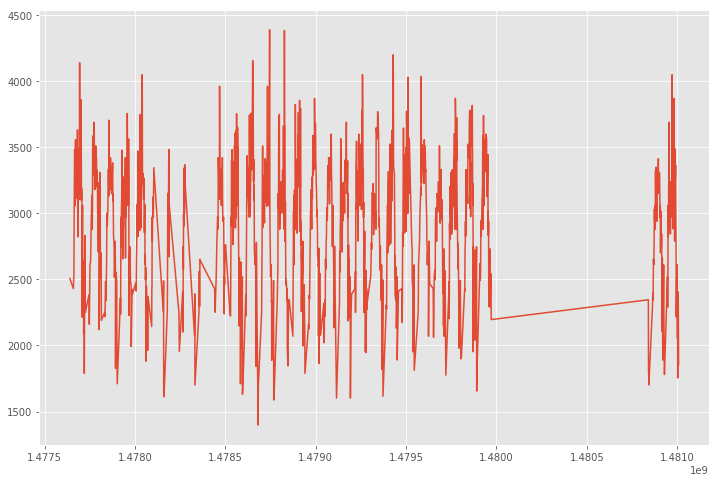

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ts, duration);

In [4]:
coll.find_one()

{'_id': '7253717_2016-10-28_HKH3O',
 'edges': {'1': {'sequence': 1,
   'from': 6293,
   'to': 3879,
   'first_timestamp': 1477639677.0,
   'last_timestamp': 1477639765.0,
   'edge_time': 88.0},
  '2': {'sequence': 2,
   'from': 3879,
   'to': 3852,
   'first_timestamp': 1477639765.0,
   'last_timestamp': 1477639811.0,
   'edge_time': 46.0},
  '3': {'sequence': 3,
   'from': 3852,
   'to': 3644,
   'first_timestamp': 1477639811.0,
   'last_timestamp': 1477639857.0,
   'edge_time': 46.0},
  '4': {'sequence': 4,
   'from': 3644,
   'to': 3645,
   'first_timestamp': 1477639857.0,
   'last_timestamp': 1477639939.0,
   'edge_time': 82.0},
  '5': {'sequence': 5,
   'from': 3645,
   'to': 3649,
   'first_timestamp': 1477639939.0,
   'last_timestamp': 1477639993.0,
   'edge_time': 54.0},
  '6': {'sequence': 6,
   'from': 3649,
   'to': 3642,
   'first_timestamp': 1477639993.0,
   'last_timestamp': 1477640065.0,
   'edge_time': 72.0},
  '7': {'sequence': 7,
   'from': 3642,
   'to': 4224,
   'fi

I want edges 11, 12, 13, and 14 (trying to predict 14)
I also want stops 11, 12 and 13

In [16]:
projection = {
    '_id': 0, 
    'edges.11.edge_time': 1, 
    'edges.12.edge_time': 1,
    'edges.13.edge_time': 1,
    'edges.14.edge_time': 1,
    'stops.11.seconds_at_stop': 1,
    'stops.12.seconds_at_stop': 1,
    'stops.13.seconds_at_stop': 1,
    'midday': 1,
    'rush_hour': 1,
    'weekend': 1
    }

feature_array = []
label_array = []

for trip_item in coll.find({}, projection):
    
    label = trip_item['edges']['14']['edge_time']
    label_array.append(label)
    
    trip_details = []
    edg11 = trip_item['edges']['11']['edge_time']
    edg12 = trip_item['edges']['12']['edge_time']
    edg13 = trip_item['edges']['13']['edge_time']
    
    wknd = trip_item['weekend']
    rhhr = trip_item['rush_hour']
    mddy = trip_item['midday']
    
#     stp11 = trip_item['stops']['11']['seconds_at_stop']
#     stp12 = trip_item['stops']['12']['seconds_at_stop']
#     stp13 = trip_item['stops']['13']['seconds_at_stop']
    
#     trip_details.extend([edg11, edg12, edg13, stp11, stp12, stp13])

#     trip_details.extend([edg11, edg12, edg13])
    
    trip_details.extend([edg11, edg12, edg13, wknd, rhhr, mddy])
    
    feature_array.append(trip_details)
    

X = np.array(feature_array)
y = np.array(label_array).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [6]:
ols = LinearRegression()

In [7]:
ols.fit(X_train, y_train);

In [8]:
ols.score(X_test, y_test)

0.10180215384667825

In [83]:
ols.coef_

array([[-0.13786858, -0.21185896, -0.23305742]])

In [9]:
# fit with statsmodels
model1 = sm.OLS(y_train,X_train)
results = model1.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     95.09
Date:                Mon, 30 Apr 2018   Prob (F-statistic):           2.66e-93
Time:                        19:51:31   Log-Likelihood:                -5172.9
No. Observations:                 944   AIC:                         1.036e+04
Df Residuals:                     938   BIC:                         1.039e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1370      0.027      5.008      0.000       0.083       0.191
x2            -0.0080      0.028     -0.282      0.778      -0.064       0.048
x3            -0.0092      0.037     -0.250      0.802      -0.081       0.063
x4            17.0396      4.325      3.940      0.000       8.552      25.527
x5            31.7862      4.685      6.785      0.000      22.592      40.980
x6            36.2956      4.833      7.511      0.000      26.812      45.780
==============================================================================
Omnibus:                     1236.620   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           188285.953
Skew:                           6.958   Prob(JB):                         0.00
Kurtosis:                      70.774   Cond. No.                         482.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train.flatten())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [11]:
regr.score(X_test, y_test.flatten())

0.31815042153474116

In [90]:
this = regr.predict(X_test)

In [92]:
this.shape

(315,)

In [94]:
hello = y_test.flatten()

In [95]:
hello.shape

(315,)

In [100]:
cheers = abs(this - hello)

In [101]:
cheers

array([1.45636126e+01, 1.54363874e+01, 1.31334202e+00, 4.56361264e+00,
       9.71355036e+00, 1.05636126e+01, 5.56361264e+00, 2.56361264e+00,
       1.43638736e+00, 2.43638736e+00, 2.15636126e+01, 1.55636126e+01,
       5.63612635e-01, 2.86449641e-01, 1.77135504e+01, 3.25636126e+01,
       2.45636126e+01, 5.71355036e+00, 7.71355036e+00, 2.05636126e+01,
       1.14363874e+01, 1.28644964e+00, 6.56361264e+00, 4.36387365e-01,
       1.85636126e+01, 9.71355036e+00, 3.71355036e+00, 3.02539261e+01,
       1.74363874e+01, 1.55636126e+01, 8.27874996e+00, 2.37135504e+01,
       2.56361264e+00, 4.28644964e+00, 3.42881487e+02, 1.05636126e+01,
       1.25636126e+01, 1.62864496e+01, 8.56361264e+00, 4.36387365e-01,
       2.56361264e+00, 1.34363874e+01, 8.56361264e+00, 1.65636126e+01,
       1.25636126e+01, 7.56361264e+00, 2.05636126e+01, 5.14363874e+01,
       2.05636126e+01, 2.46953546e+01, 4.74363874e+01, 1.37135504e+01,
       5.43638736e+00, 1.40119339e+02, 1.15636126e+01, 7.13550359e-01,
      

In [102]:
cheers.mean()

22.439838135602486

In [103]:
y.shape

(1259, 1)

In [104]:
y.flatten().mean()

48.72120730738681

## Normalize?

In [17]:
X_norm = normalize(X)
y_norm = normalize(y)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.25)

In [18]:
# fit with statsmodels
model1 = sm.OLS(y_train,X_train)
results = model1.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     7481.
Date:                Mon, 30 Apr 2018   Prob (F-statistic):               0.00
Time:                        19:56:01   Log-Likelihood:                 509.75
No. Observations:                 944   AIC:                            -1008.
Df Residuals:                     938   BIC:                            -978.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7481      0.014     53.195      0.000       0.721       0.776
x2             0.5795      0.016     37.051      0.000       0.549       0.610
x3             0.4193      0.019     22.139      0.000       0.382       0.457
x4             0.6807      0.148      4.587      0.000       0.389       0.972
x5             0.9625      0.078     12.279      0.000       0.809       1.116
x6             0.5111      0.049     10.375      0.000       0.414       0.608
==============================================================================
Omnibus:                      598.175   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15519.803
Skew:                          -2.440   Prob(JB):                         0.00
Kurtosis:                      22.255   Cond. No.                         30.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
sm_predict = results.predict(X_test)

In [24]:
from sklearn.metrics import r2_score

In [27]:
r2_score(y_test, sm_predict.reshape(-1,1))

0.19595145589302387

In [26]:
sm_predict.reshape(-1,1)

(315,)

In [19]:
ols = LinearRegression()
ols.fit(X_train, y_train)
ols.score(X_test, y_test)

0.22155820598129283

In [28]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train.flatten())
regr.score(X_test, y_test.flatten())

0.45724623833882894